# Data Ted
## Analisi dei Ted Talk
---
#### Matano Francesco S5253162
#### Vassallo Edoardo S4965918 
---

# Indice
---
0. Preparativi
    1. Librerie Imporate
    2. Funzioni utilizzate per il notebook
    3. Definizione di array globali utilizzati all'interno del notebook
    4. Import Dataset
1. Pulizia Dati
2. Visualizzazione dei Dati
    1. Visualizzazione dei ted talk per tag
    2. Visualizzazione dei ted talk usciti nel tempo
3. Test Statistici
    1. T-TEST sui dati temporali
    2. T-TEST sui TAG
    3. TEST CHI-QUADRO
4. Modello predittivo
    1. Regressione anno -> numero video usciti
    2. Regressione id_tag, likes -> views
5. Clustering
    1. Clustering date_int, views e likes
--- 

# Introduzione ed Obiettivi
Il nostro obbiettivo è analizzare l'evoluzione nel tempo dei dati in nostro possesso, relativi ai video pubblicati sulla piattaforma Ted-Ed. <br> Secondariamente, intendiamo studiare le eventuali differenze fra sottogruppi della popolazione, ottenuti tramite operazioni di quantizzazione e tagging

# 0. Preparativi

> ## Librerie importate

In [26]:
# OS utilities
import os
# Math functions
import math
import numpy as np
# Graphs
import matplotlib.pyplot as plt 
# For working with dataframes
import pandas as pd 
# For working with dates
import datetime as dt
# Statistical functions
import scipy.stats as stats
# FOr prediction models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# For normalization
from sklearn import preprocessing
# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# from sklearn.linear_model import LogisticRegression

> ## Funzioni utilizzate per il notebook

In [27]:
def print_stats_field(df, field):
    print("--------------------------------------------"   )
    print("Statistiche relative a:  ", field               )
    print("--------------------------------------------"   )
    print("Media:                   ",  df[field].mean()   )
    print("Moda:                    ",  df[field].mode()[0])
    print("Mediana:                 ",  df[field].median() )
    print("Varianza:                ",  df[field].var()    )
    print("Deviazione standard:     ",  df[field].std()    ) 
    print("--------------------------------------------"   )

In [28]:
def plot_olap_on_first_dim(olap_df, cols, xlabel, ylabel, list_of_labels):

    rows = (len(list_of_labels) // cols) + 1

    plt.figure(figsize=(20, 30))

    for element in range(0, len(list_of_labels)):
        plt.subplot(rows, cols, element+1)
        plt.title(list_of_labels[element])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.imshow(olap_df[element, :, :])
        plt.colorbar()

        for (j,i),label in np.ndenumerate(olap_df[element, :, :]):
            plt.text(i,j,"{:.0f}".format(label),ha='center',va='center')

    plt.show()

In [29]:
def print_ttest_1samp(first_dataset, second_dataset, column, name):
    t, p_value = stats.ttest_1samp(a = first_dataset[column].values, popmean= second_dataset[column].mean())
    print("\nt-test on ", name, ":")
    print('Valore test: ', t)
    print('P-value: ', p_value)

In [30]:
def print_chi_squared(obs, exp, name):
    chi_squared, p_value = stats.chisquare(f_obs= obs, f_exp = exp)
    print("\nchi-squared on ", name, ":")
    print('Chi-quadrato: ', chi_squared)
    print('P-value: ', p_value)

In [100]:
def plot_3d_clusters(df, x_label, y_label, z_label, n_cluster, make_plot = 0):
    scaler = preprocessing.MinMaxScaler()
    tmp = df[[x_label, y_label, z_label]]
    scaler.fit(tmp)
    scaled = scaler.fit_transform(tmp)
    scaled_df = pd.DataFrame(scaled, columns=tmp.columns)
    kmeans = KMeans(n_clusters= n_cluster, random_state=0, n_init='auto')
    kmeans.fit(scaled_df)
    
    if make_plot != 0:
        fig = plt.figure()

        ax = plt.axes(projection ='3d')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_zlabel(z_label)
        ax.scatter(scaled_df[x_label].values, scaled_df[y_label].values, scaled_df[z_label].values, c = kmeans.labels_, alpha=0.5)
    # generate_gif_of_3d_plot(ax, fig)
    return silhouette_score(scaled_df, kmeans.labels_), kmeans.cluster_centers_


In [32]:
def plot_3d_prediction(xy_struct, z_struct, x_label, y_label, lin_reg, plt):
    ###Create x, y surface meshgrid
    x_surf, y_surf = np.meshgrid(
                                  np.linspace(xy_struct[x_label].min(), xy_struct[x_label].max(), 100),
                                  np.linspace(xy_struct[y_label].min(), xy_struct[y_label].max(), 100)
                                )

    onlyX = pd.DataFrame({x_label : x_surf.ravel(), y_label: y_surf.ravel()})
    fittedY = np.array(lin_reg.predict(onlyX))
    z_pred = lin_reg.predict(xy_struct)

    print('Score:', lin_reg.score(xy_valid, z_valid))
    
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color='green', alpha=0.3)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_struct, color='red', alpha=0.7)
    ax.scatter(xy_struct[x_label].values, xy_struct[y_label].values, z_pred)
    ax.set_title('Piano di predizione e dati di training')
    # generate_gif_of_3d_plot(ax, fig)
    plt.show()
    return z_pred


In [33]:
def generate_gif_of_3d_plot(ax, fig):
    # DA INSTALLARE PER LA GENERAZIONE DELLE GIF
    import imageio.v2 as imageio # pip install imageio
    from natsort import natsorted # pip install natsort

    png_dir = 'gif_production/resources'
    images = []

    # generiamo i frame
    for ii in np.arange(0, 360, 1):
          ax.view_init(elev=32, azim=ii)
          fig.savefig('gif_production/resources/frame_%d.png' % ii)

    # generiamo la gif
    for file_name in natsorted(os.listdir(png_dir)):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

    # Make it pause at the end so that the viewers can ponder
    for _ in range(10):
        images.append(imageio.imread(file_path))

    imageio.mimsave('gif_production/gif/movie.gif', images, fps=120)


In [34]:
def MAE(valid, pred_valid):
    if len(valid) != len(pred_valid):
        print("Il numero di dati validi deve essere uguale a quelli predetto")
        return -1
    return_val = 0
    for x in range(len(valid)):
        return_val += abs(valid[x] - pred_valid[x])
    return (return_val/len(valid))

In [35]:
def MSE(valid, pred_valid):
    if len(valid) != len(pred_valid):
        print("Il numero di dati validi deve essere uguale a quelli predetto")
        return -1
    return_val = 0
    for x in range(len(valid)):
        return_val += math.pow((valid[x] - pred_valid[x]), 2)
    return (return_val/len(valid))

In [36]:
def RMSE(valid, pred_valid):
    mse_ret = MSE(valid, pred_valid)
    return math.sqrt(mse_ret)

In [37]:
def plot_corr_matrix(df, label_list, title):
    corr_matrix = df[label_list].corr()
    plt.title(title)
    plt.imshow(corr_matrix)
    plt.xticks([x for x in range(len(label_list))], label_list )
    plt.yticks([x for x in range(len(label_list))], label_list )
    plt.colorbar()
    for (j,i),label in np.ndenumerate(corr_matrix):
        plt.text(i,j,"{:.4f}".format(label),ha='center',va='center')

In [38]:
def plot_cov_matrix(df, labels, title):
    cov_matrix = daTed[labels].cov()
    plt.title(title)
    plt.imshow(cov_matrix)
    plt.xticks([x for x in range(len(labels))], labels )
    plt.yticks([x for x in range(len(labels))], labels )
    plt.colorbar()
    for (j,i),label in np.ndenumerate(cov_matrix):
        plt.text(i,j,"{:.2f}".format(label),ha='center',va='center')

> ##  Definizione di array globali utilizzati all'interno del notebook
 (N.B.) Nella quantizzazione relativa agli anni, si è deciso di catalogare tutti gli anni precedenti al 2000 in un unico gruppo, sulla base dei componenti della popolazione.<br>
 Si è anche deciso di quantizzare l'insieme dei dati per tag (non essendoci il campo tag vero e proprio ci siamo ricavati il tag cercando la parola nel titolo del Ted-Ed) abbiamo preso in considerazione i tag più in voga sul sito dei Ted-Ed: climate, COVID, health, war, AI, like, love, brain, life, science, culture, data e music.

In [39]:
#quantizzazione dell views
quantize_views = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '1M-20M', '>20M'  ]
#quantizzazione dei likes
quantize_likes = ['<10K',  '10K-100K', '100K-500K', '500K-1M', '>1M'             ]
#lista dei tag
tag            = ["climate","COVID","health","war","AI","like","love",
                  "brain","life","science","culture","data","music" ] 

---

> ## Import Dataset

In [40]:
daTed = pd.read_csv("data_ted.csv")
daTed.info()
daTed.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5440 entries, 0 to 5439
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5440 non-null   object
 1   author  5439 non-null   object
 2   date    5440 non-null   object
 3   views   5440 non-null   int64 
 4   likes   5440 non-null   int64 
 5   link    5440 non-null   object
dtypes: int64(2), object(4)
memory usage: 255.1+ KB


,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


> Creazione della colonne tag e id_tag nel dataframe in cui: nel primo c'è il nome del tag a cui il ted talk fa parte mentre nella seconda c'è l'id del tag nella lista globale tag. 

In [41]:
daTed["tag"] = "nontrovato"
daTed["id_tag"] = -1
for x in range(len(tag)):
    daTed.loc[daTed["title"].str.contains(tag[x]), "tag"] = tag[x]
    daTed.loc[daTed["title"].str.contains(tag[x]), "id_tag"] = x
print("Numero dei ted talk trovati relativi ai tag")
daTed["tag"].value_counts()

Numero dei ted talk trovati relativi ai tag


tag
nontrovato    4606
life           179
brain           85
climate         82
health          70
war             68
science         62
like            62
data            53
love            53
music           48
AI              35
COVID           19
culture         18
Name: count, dtype: int64

# 1. Pulizia Dati

>Analizzando i nostri dati, abbiamo ritrovato i seguenti errori:
>1. È presente una riga con autore mancante

In [42]:
print(daTed.loc[(daTed['author'].isnull())])

                   title author           date  views  likes  \
3039  Year In Ideas 2015    NaN  December 2015    532     15   

                                          link         tag  id_tag  
3039  https://ted.com/talks/year_in_ideas_2015  nontrovato      -1  


>2. Due delle righe presenti vengono erroneamente datati al gennaio 1970, data sospetta in quanto valore minimo dei timestamp UNIX.<br> L'errore è stato verificato cercando i video in questione online.

In [43]:
print(daTed.loc[(daTed['date'] == 'January 1970')])

                                 title          author          date   views  \
736               Innovations in sleep      Beautyrest  January 1970   60000   
738  Love letters to what we hold dear  Debbie Millman  January 1970  192000   

     likes                                               link         tag  \
736   1800  https://ted.com/talks/beautyrest_innovations_i...  nontrovato   
738   5700  https://ted.com/talks/debbie_millman_love_lett...  nontrovato   

     id_tag  
736      -1  
738      -1  


>Siccome questi errori riguardano solo un paio di righe, si è deciso di correggere le righe, invece che eliminarle, nel seguente modo:
>1. Vedendo [il video in questione](https://www.ted.com/talks/year_in_ideas_2015) si è visto che si tratta di un video celebrativo realizzato dall'azienda stessa. Si è deciso quindi di attribuirlo all'autore *"TED"*.

In [44]:
daTed.loc[(daTed['author'].isnull()), 'author'] = 'TED'
print(daTed.loc[(daTed['author'].isnull())])

Empty DataFrame
Columns: [title, author, date, views, likes, link, tag, id_tag]
Index: []


>2. Similmente, possiamo rintracciare la data di pubblicazione dei video online *"Innovations in sleep"* è stato [caricato](https://youtu.be/mo264ECPacQ?si=O2mQA_2kww7flGm3) sulla pagina Youtube di TED nel Luglio 2020.<br>  *"Love letters to what we hold dear"* è stato presentato nel corso di TED2020.<br> Cercando la [scaletta](https://tedlive.ted.com/webcasts/t2020/session/419) dell'evento, scopriamo che è stato presentato nel Giugno di quell'anno.

In [45]:
daTed.loc[(daTed['title'] == 'Innovations in sleep'),              'date'] = 'July 2020'
daTed.loc[(daTed['title'] == 'Love letters to what we hold dear'), 'date'] = 'June 2020'

print(daTed.loc[(daTed['date'] == 'January 1970')])

Empty DataFrame
Columns: [title, author, date, views, likes, link, tag, id_tag]
Index: []


>L'ultima correzione necessaria è al **formato delle date**. <br>
Al momento la data di pubblicazione è memorizzata come una stringa mese-anno. <br>Decidiamo di tradurla nel tipo *datetime*, per aiutare in seguito.

In [46]:
daTed["date"] = pd.to_datetime(daTed['date'], format='%B %Y')

# 2. Visualizzazione dei dati

>La nostra analisi si basa principalmente sullo studio dell'evoluzione temporale dei dati e anche sull'analisi dei video basandoci su dei tag.<br> Cominciamo quindi mostrando un grafico del numero di uscite rispetto ai tag per poi passare all'analisi dei ted usciti durante gli anni.

> ## Visualizzazione dei ted talk per tag
Abbiamo creato un nuovo dataframe daTag togliendo tutti i video dei ted-talk che non erano inclusi in nessun dei tag sopracitati.

<AxesSubplot: title={'center': 'Numero di Video per tag'}, xlabel='Tag', ylabel='N° Video'>

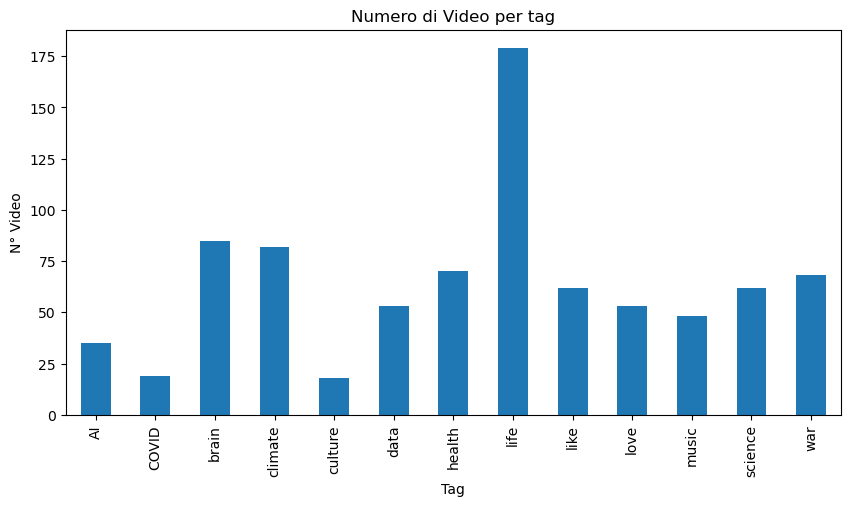

In [47]:
daTag = daTed[daTed["id_tag"] != -1]
daTag.groupby(daTag.tag)['tag'].count().plot( kind    = 'bar', 
                                              figsize = (10,5), 
                                              ylabel  = "N° Video", 
                                              xlabel  = "Tag", 
                                              title   = "Numero di Video per tag" )

>Cerchiamo di vedere ora se c'è una correlazione tra il tag in cui è incluso il video e il numero di views che riceve quest'ultimo tramite una matrice di correlazione tra: tag, views e likes.

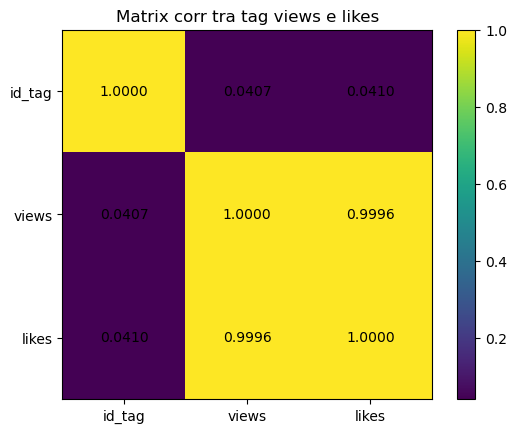

In [48]:
plot_corr_matrix(daTag, ["id_tag", "views", "likes"], "Matrix corr tra tag views e likes" )

>Da questa matrice si può notare come la correlazione tra le varie variabili (id_tag, views e likes) non è molto forte.

> ## Visualizzazione dei ted talk usciti nel tempo

<AxesSubplot: title={'center': 'Numero di Video per Anno'}, xlabel='Anno', ylabel='N° Video'>

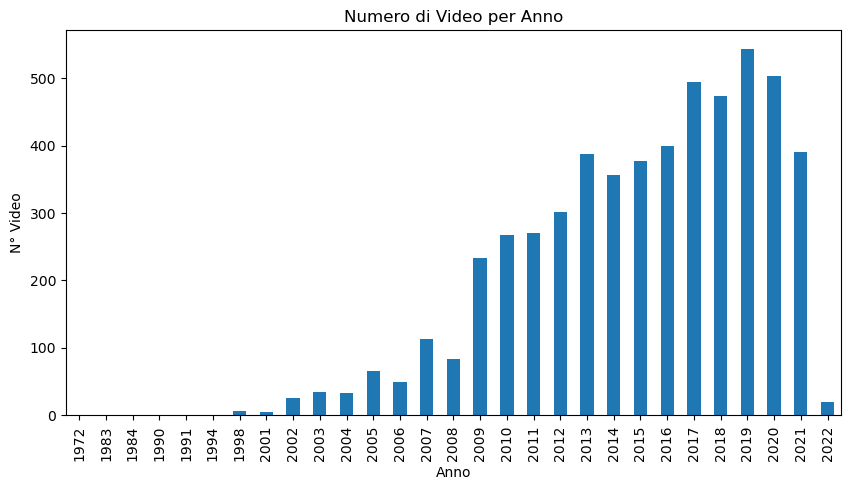

In [49]:
daTed.groupby(daTed.date.dt.year)['title'].count().plot( kind    = 'bar', 
                                                         figsize = (10,5), 
                                                         ylabel  = "N° Video", 
                                                         xlabel  = "Anno", 
                                                         title   = "Numero di Video per Anno" )

>Da questo grafico possiamo notare la crescita negli anni del numero di video, in particolare in seguito al 2005. Inoltre, la maggior parte dei video è uscita nel decennio 2010-2019 (si può anche vedere come l'anno 2019 sia stato l'anno con il maggior numero di video usciti). Le statistiche relative all'anno sembrano confermare queste osservazioni<br>

In [58]:
# Quantizzazione per anno
## p.s. min year: 1972
##      max year: 2022

daTed["date_year"] = daTed["date"].dt.year
quantize_years = sorted(daTed["date_year"].unique())

print_stats_field(daTed, "date_year")

--------------------------------------------
Statistiche relative a:   date_year
--------------------------------------------
Media:                    2015.0152573529413
Moda:                     2019
Mediana:                  2016.0
Varianza:                 20.2702212979795
Deviazione standard:      4.502246250259919
--------------------------------------------


Vediamo ora di studiare la **qualità** di questi video, sulla base dei valori di like e visualizzazioni. Realizziamo a tal scopo, un **OLAP** ad hoc, **quantizzando** le colonne dei likes, views, e data di pubblicazione.

In [59]:
# Quantizzazione per quantità di views
## p.s. max views: 72M

daTed.loc[daTed['views'].between(0        , 9999    , 'both'), 'views_quant'] = quantize_views[0]
daTed.loc[daTed['views'].between(10000    , 99999   , 'both'), 'views_quant'] = quantize_views[1]
daTed.loc[daTed['views'].between(100000   , 499999  , 'both'), 'views_quant'] = quantize_views[2]
daTed.loc[daTed['views'].between(500000   , 999999  , 'both'), 'views_quant'] = quantize_views[3]
daTed.loc[daTed['views'].between(1000000  , 19999999, 'both'), 'views_quant'] = quantize_views[4]
daTed.loc[daTed['views'].between(20000000 , 80000000, 'both'), 'views_quant'] = quantize_views[5]

# Quantizzazione per quantità di likes
## p.s. max likes: 2.1M

daTed.loc[daTed['likes'].between(0       , 9999    , 'both'), 'likes_quant'] = quantize_likes[0]
daTed.loc[daTed['likes'].between(10000   , 99999   , 'both'), 'likes_quant'] = quantize_likes[1]
daTed.loc[daTed['likes'].between(100000  , 499999  , 'both'), 'likes_quant'] = quantize_likes[2]
daTed.loc[daTed['likes'].between(500000  , 999999  , 'both'), 'likes_quant'] = quantize_likes[3]
daTed.loc[daTed['likes'].between(1000000 , 10000000, 'both'), 'likes_quant'] = quantize_likes[4]

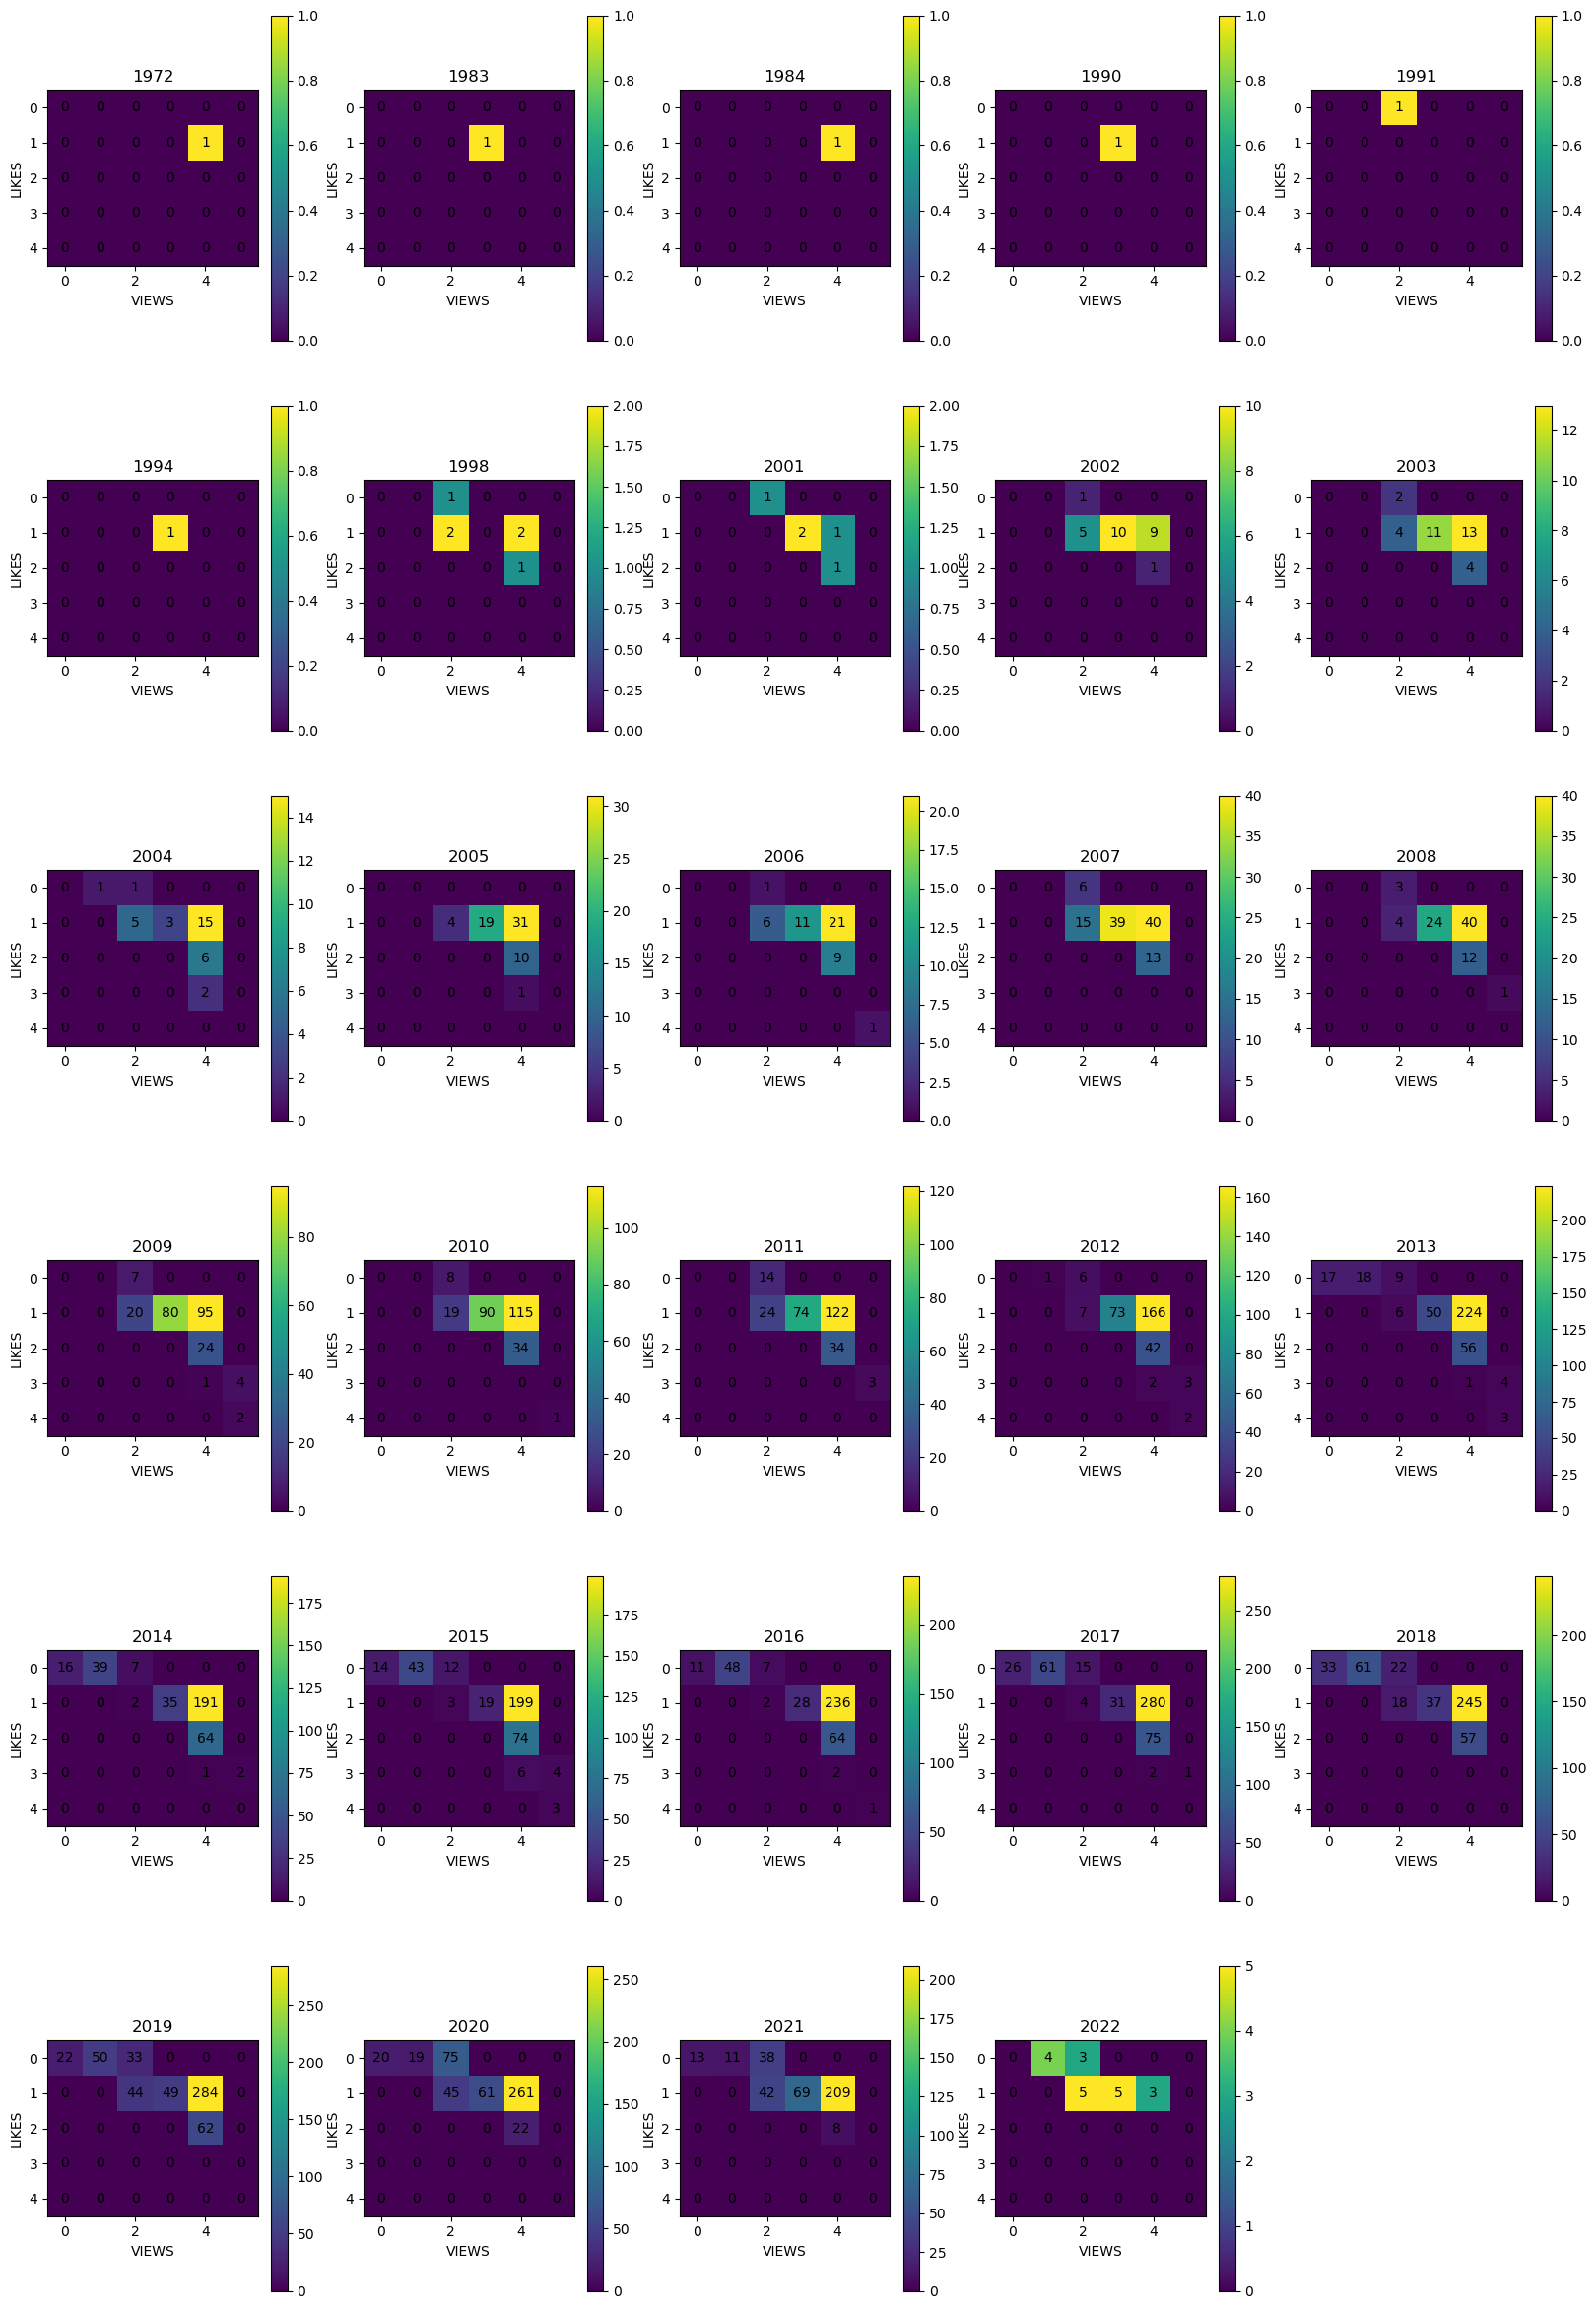

In [60]:
##OLAP che ha come dimensioni: x: le date quantizzate, y: le views quantizzate e z: il numero di like quantizzati
OLAP  = np.zeros((len(quantize_years), len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    views_class = daTed[daTed['views_quant'] == quantize_views[z]]
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            OLAP[x,y,z] = np.sum(
                                (views_class['likes_quant'] == quantize_likes[y]) & 
                                (views_class['date_year']  == quantize_years[x] ) )

plot_olap_on_first_dim(OLAP, 5, "VIEWS", "LIKES", quantize_years)

>Dalla visualizzazione OLAP notiamo che, nonostante la quantità dei video vari notevolmente fra anno ed anno, il rapporto fra views e likes rimane quasi sempre costante (la maggior parte dei video sembra possedere 1M-20M visualizzazioni e 10K-100K like). <br>
Questo potrebbe quindi implicare un **rapporto** fra le due variabili.
<br>
I dati stampati di seguito corrispondono con la visualizzazione dell'OLAP.

In [61]:
print_stats_field(daTed, 'views')
print_stats_field(daTed, 'likes') 

--------------------------------------------
Statistiche relative a:   views
--------------------------------------------
Media:                    2061575.9579044117
Moda:                     1300000
Mediana:                  1300000.0
Varianza:                 12724186465893.203
Deviazione standard:      3567097.7651156695
--------------------------------------------
--------------------------------------------
Statistiche relative a:   likes
--------------------------------------------
Media:                    62607.616727941175
Moda:                     39000
Mediana:                  40500.0
Varianza:                 11587826975.425684
Deviazione standard:      107646.76946116722
--------------------------------------------


>Per studiare la correlazione intuita, stampiamo il grafico relativo al rapporto fra views e likes

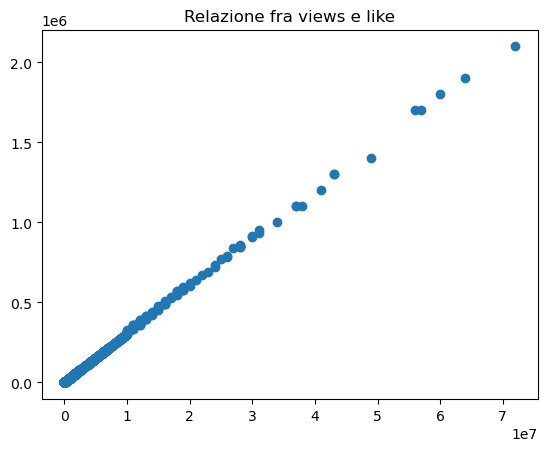

In [62]:
plt.title("Relazione fra views e like")
plt.scatter(daTed["views"], daTed["likes"])

>Il grafico ci mostra ancora più evidenza di questo rapporto. <br>
Calcolando covarianza e correlazione, la loro relazione appare ancora più ovvia

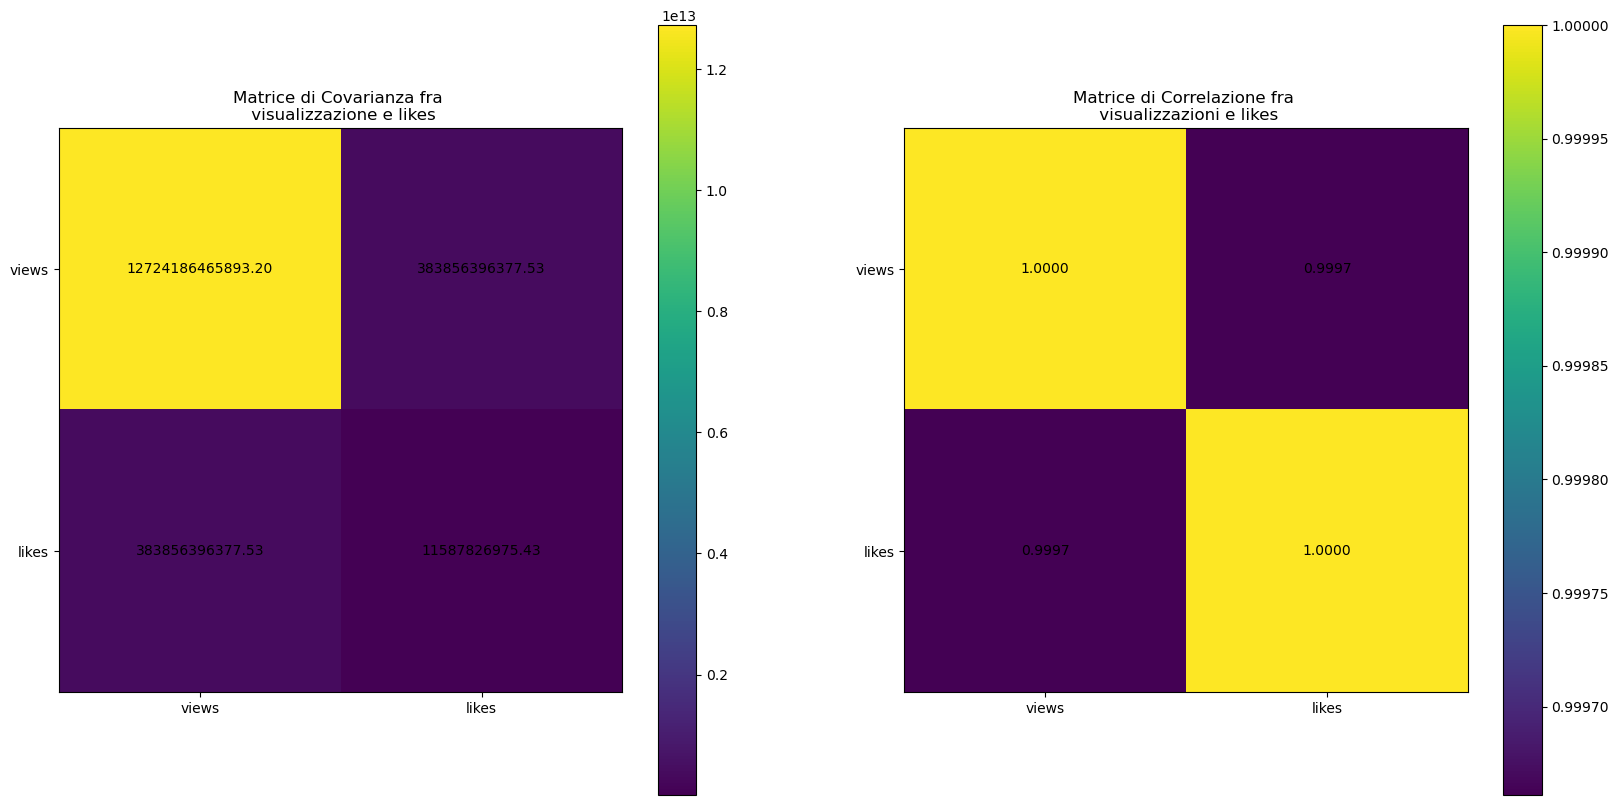

In [63]:
plt.figure(figsize=(20, 10)) 
plt.subplot(1, 2, 1)
plot_cov_matrix(daTed, ["views", "likes"], "Matrice di Covarianza fra \n visualizzazione e likes")
plt.subplot(1, 2, 2)
plot_corr_matrix(daTed, ["views", "likes"], "Matrice di Correlazione fra \n visualizzazioni e likes")

# 3. Test Statistici

> ## T-TEST sui dati temporali
Cominciamo la nostra analisi osservando come sono distribuiti i valori delle views nelle varie annate:

<AxesSubplot: title={'center': 'views'}, xlabel='date_year'>

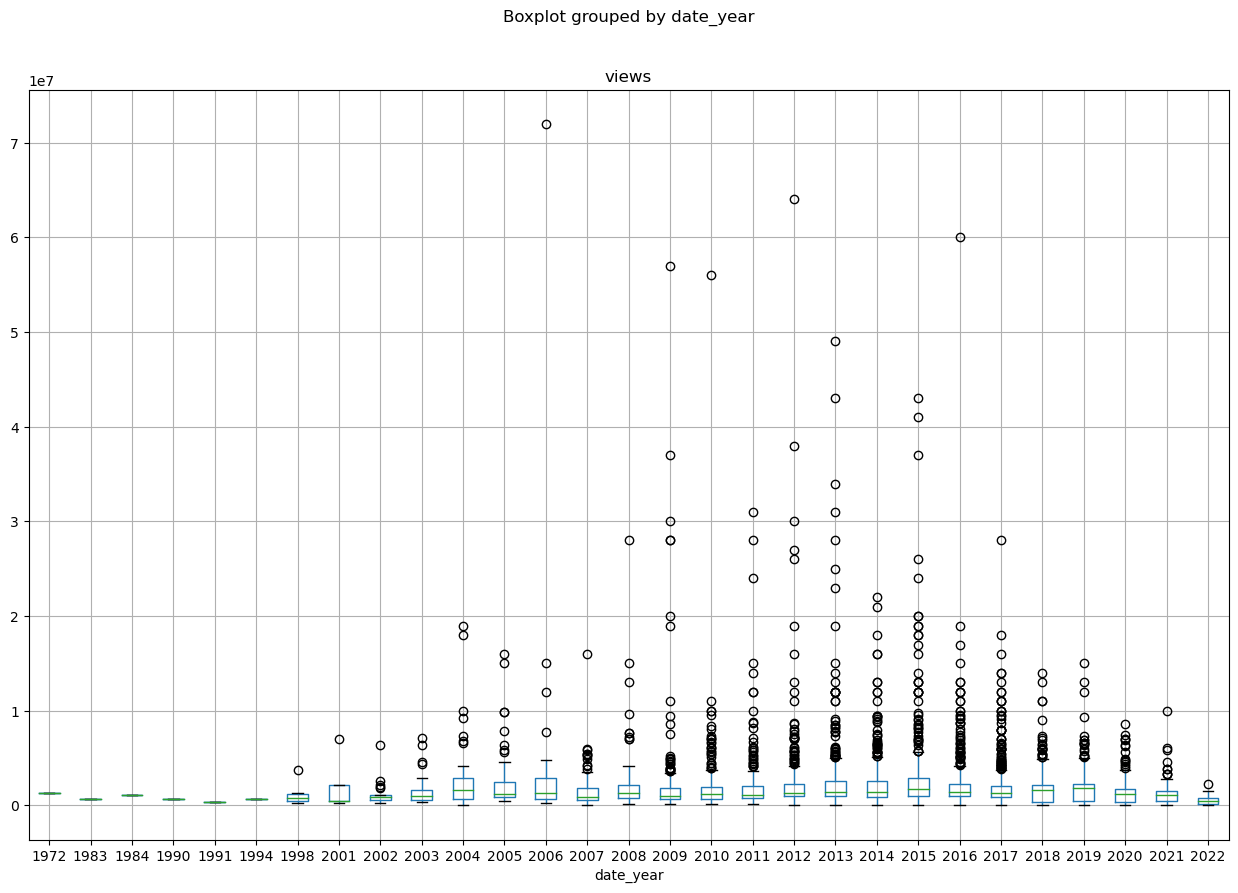

In [66]:
daTed.boxplot(column = "views", by = "date_year", figsize=(15, 10))

>Come si può notare dai boxplot qui sopra sono presenti numerosi outliers nei dati, specie negli anni 10's. <br> Questo è comprensibile, in quanto quelli sono gli anni con il maggior numero di video, e ci aspettiamo quindi generalmente una varianza molto alta. <br> Notiamo che nonostante questi outlier, il grosso dei dati sembrano coincidere fra gli anni.<br>
Proviamo quindi ad applicare un t-test sulle annate (con livello di significatività dello 0.05), ove possibile, allo scopo di riconoscere anni che si discostano particolarmente dalla popolazione:

In [67]:
popolazione = len(daTed)

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["date_year"] == quantize_years[x]], daTed, "views", quantize_years[x])



t-test on  2003 :
Valore test:  -1.6220743309082197
P-value:  0.11430419047759649

t-test on  2004 :
Valore test:  1.6483243246368204
P-value:  0.10907151218856788

t-test on  2005 :
Valore test:  0.9244821610187695
P-value:  0.3587080119761623

t-test on  2006 :
Valore test:  1.1058932244066195
P-value:  0.27428484729210995

t-test on  2007 :
Valore test:  -2.765894607095807
P-value:  0.00664154617990903

t-test on  2008 :
Valore test:  0.9855743843117651
P-value:  0.32720638363810606

t-test on  2009 :
Valore test:  0.8896853708003017
P-value:  0.37455645574427776

t-test on  2010 :
Valore test:  -0.35970547331330066
P-value:  0.7193528058847316

t-test on  2011 :
Valore test:  0.29977056959568793
P-value:  0.7645828122513227

t-test on  2012 :
Valore test:  1.9468762427830237
P-value:  0.052479531668387265

t-test on  2013 :
Valore test:  2.6748226813474663
P-value:  0.0077940104199484056

t-test on  2014 :
Valore test:  1.568125068405824
P-value:  0.11774033494700097

t-test on  2

>Si può vedere dai risultati ottenuti come nella maggior parte dei casi in cui è possibile effettuare il t-test, non è possibile rigettare l'ipotesi nulla, e dire se il valore medio è significativamente differente da quello della popolazione.<br>Le eccezioni sono gli anni 2007, 2013, 2015, i quali presentano un p-value inferiore allo 0.05. In particolare, il valore del 2015 è di molto inferiore. Questo ci permette di rigettare l'opinione nulla in questo caso specifico, e dire che il comportamento dei video usciti nel 2015 è statisticamente diverso da quello della popolazione completa<br> <br>

>Listiamo di seguito i valori medi per comprendere i risultati precedenti

In [68]:
print("Media di tutto il dataset", daTed['views'].mean())

for x in range(len(quantize_years)):
    campione =  len(daTed.loc[daTed["date_year"] == quantize_years[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
        print("Media anno", quantize_years[x], ": ", daTed.loc[daTed["date_year"] == quantize_years[x]]['views'].mean())


Media di tutto il dataset 2061575.9579044117
Media anno 2003 :  1599823.5294117648
Media anno 2004 :  3405393.9393939395
Media anno 2005 :  2422738.446153846
Media anno 2006 :  3696122.4285714286
Media anno 2007 :  1563283.185840708
Media anno 2008 :  2476285.7023809524
Media anno 2009 :  2393283.261802575
Media anno 2010 :  1978074.9026217228
Media anno 2011 :  2124273.05904059
Media anno 2012 :  2659556.2913907287
Media anno 2013 :  2738498.7036082475
Media anno 2014 :  2309950.411764706
Media anno 2015 :  3062971.167108753
Media anno 2016 :  2328057.3834586465
Media anno 2017 :  2017962.8282828282
Media anno 2018 :  1716400.8393234673
Media anno 2020 :  1264803.578528827
Media anno 2021 :  1101868.4615384615


> ## T-TEST sui TAG
> Proviamo ad effettuare un ragionamento analogo sui sottogruppi formati dai tag:

In [69]:
popolazione = len(daTed)

for x in range(len(tag)):
    campione =  len(daTed.loc[daTed["tag"] == tag[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
            print_ttest_1samp(daTed.loc[daTed["tag"] == tag[x]], daTed, "views", tag[x])



t-test on  climate :
Valore test:  -5.177082817730289
P-value:  1.6076970864103636e-06

t-test on  health :
Valore test:  -6.042004170258757
P-value:  6.88273753224258e-08

t-test on  war :
Valore test:  -2.0887054622622268
P-value:  0.040536769876744747

t-test on  AI :
Valore test:  -1.0886342589441442
P-value:  0.2839718099834681

t-test on  like :
Valore test:  0.2310276445803188
P-value:  0.8180664739301396

t-test on  love :
Valore test:  1.9961747944229455
P-value:  0.05116368008401059

t-test on  brain :
Valore test:  2.7782233434701493
P-value:  0.006740922735554669

t-test on  life :
Valore test:  0.6451195928897905
P-value:  0.5196803193601651

t-test on  science :
Valore test:  -1.3987254094260997
P-value:  0.16695925373998735

t-test on  data :
Valore test:  -7.162602043056196
P-value:  2.7238759147582606e-09

t-test on  music :
Valore test:  -1.5183925485662615
P-value:  0.13561405622225464


In [70]:
print("Media di tutto il dataset", daTed['views'].mean())

for x in range(len(tag)):
    campione =  len(daTed.loc[daTed["tag"] == tag[x]])
    if( (campione > 30) and (popolazione > campione*10) ):
        print("Media tag", tag[x], ":    \t", daTed.loc[daTed["tag"] == tag[x]]['views'].mean())

Media di tutto il dataset 2061575.9579044117
Media tag climate :    	 1383764.6341463414
Media tag health :    	 1301220.0
Media tag war :    	 1705279.3970588236
Media tag AI :    	 1778620.0
Media tag like :    	 2112009.6774193547
Media tag love :    	 2991754.716981132
Media tag brain :    	 3111788.2352941176
Media tag life :    	 2286318.4357541897
Media tag science :    	 1611612.8870967743
Media tag data :    	 1092473.5849056605
Media tag music :    	 1540102.0833333333


>Da questi risultati, possiamo dire che il p-value è sufficentemente basso solo nel caso delle righe taggate come "war" e "brain".<br> Per essi possiamo dire di rigettare l'ipotesi nulla.<br> Non possiamo dire niente sulle categorie rimanenti.

---

> ## TEST CHI-QUADRO
Ora, sulla base delle analisi precedenti, proviamo ad effettuare un test chi quadro d'indipendenza fra le views ed i likes di un video, allo scopo di confermare la loro correlazione.<br> Useremo sempre un intervallo di confidenza di 0.05 

In [71]:
chi_square = np.zeros((len(quantize_likes), len(quantize_views)))

for z in range(0, len(quantize_views)):
    for y in range(0, len(quantize_likes)):
        for x in range(0, len(quantize_years)):
            chi_square[y,z] += OLAP[x, y, z]
res =  stats.chi2_contingency(chi_square)
print("Test Chi Quadro d'indipendenza: \nresult: \t", res.statistic, "\np-value: \t", res.pvalue)

Test Chi Quadro d'indipendenza: 
result: 	 8487.892386073949 
p-value: 	 0.0


>Il valore statistico è di gran lunga superiore al valore corrispondente della distribuzione chi-quadrato (10,851). Insieme alla minima dimensione del p-value, questo ci conferma la correlazione fra le due proprietà

---

# 4. Modello predittivo

> ## Regressione anno -> numero video usciti

>Proviamo a costruire un modello predittivo in grado di predire il numero di video usciti data la data. Lo faremo in due modi:
>+ Utilizzando come input la data completa
>+ Utilizzando come input l'anno della data

In [87]:
daTed['count_date'] = daTed.groupby(['date'])['title'].transform('count')
daTed['count_year'] = daTed.groupby(['date_year'])['title'].transform('count')

for x in quantize_years: 
    daTed.loc[daTed['date_year'] == x, 'mean_views_year'] = daTed.loc[daTed['date_year'] == x]["views"].mean()

Score: 0.03010272300742467


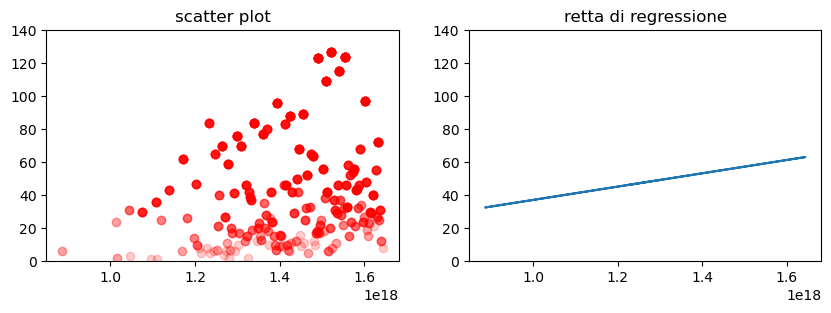

In [88]:
x = daTed[["date"]].values.astype(float)
y = daTed["count_date"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)
regressor = LinearRegression()
lin_reg = regressor.fit(x_train, y_train) 

print('Score:', lin_reg.score(x_valid, y_valid))

y_hat = lin_reg.predict(x_valid)
plt.figure(figsize=(10, 3)) 

plt.subplot(1, 2, 1)
plt.title("scatter plot")
plt.ylim([0, 140])
plt.scatter(x_valid,y_valid,c='r',alpha=0.2)

plt.subplot(1, 2, 2)
plt.title("retta di regressione")
plt.ylim([0, 140])
plt.plot(x_valid,y_hat)

plt.show()

Score: 0.7297070457520423


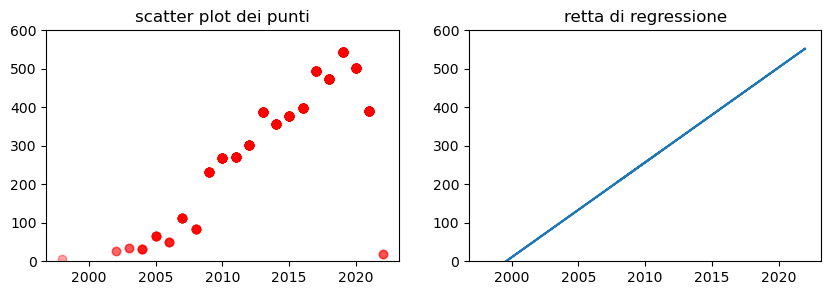

In [74]:
x = daTed[["date_year"]].values.astype(float)
y = daTed["count_year"]
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)
regressor = LinearRegression()
lin_reg = regressor.fit(x_train, y_train)

print('Score:', lin_reg.score(x_valid, y_valid))

plt.figure(figsize=(10, 3)) 

plt.subplot(1, 2, 1)
y_hat = lin_reg.predict(x_valid)
plt.title("scatter plot dei punti")
plt.ylim([0, 600])
plt.scatter(x_valid, y_valid,c='r',alpha=0.2) 

plt.subplot(1, 2, 2)
plt.title("retta di regressione")
plt.ylim([0, 600])
plt.plot(x_valid,y_hat) 

plt.show()

>Possiamo vedere come il modello che utilizza le date sembra essere meno preciso di quello che usa gli anni. Questo è probabilmente dovuto al maggior numero di punti, i quali sono presenti anche in parti inferiori. Il modello che usa gli anni ha quindi i dati "organizzati" in modo più significativo, limitando il numero di outlier <br>

>Valutiamo le statistiche di questo modello con quelle del modello nullo, realizzato predicendo sempre il valore medio:

In [75]:
print("Statistiche Modello sugli anni:")
print ('MAE: \t',  MAE(list(y_valid), list(y_hat)))
print ('MSE: \t',  MSE(list(y_valid), list(y_hat)))
print ('RMSE:\t',  RMSE(list(y_valid), list(y_hat)))

#calcolate lo score medio
mean_count_year = y_valid.mean()

# create la nuova x con lo stesso numero di campioni del validation set originale, e con tutti i valori uguali al valore medio dello score appena calcolato
null_model_y = [mean_count_year] * y_valid.shape[0]

print("Statistiche Modello nullo:")
print ('MAE: \t',  MAE(list(y_valid), list(null_model_y)))
print ('MSE: \t',  MSE(list(y_valid), list(null_model_y)))
print ('RMSE:\t',  RMSE(list(y_valid), list(null_model_y)))

Statistiche Modello sugli anni:
MAE: 	 39.64883799027749
MSE: 	 4420.828271123733
RMSE:	 66.48930944989377
Statistiche Modello nullo:
MAE: 	 96.92415927768157
MSE: 	 16355.691858205839
RMSE:	 127.88937351557337


> Vediamo che i valori sono inferiori a quelli del modello nullo, confermando la bontà del modello

---

> ## Regressione id_tag, likes -> views

>Proviamo a costruire un modello predittivo in grado di predire il numero di views di un video basandoci sul tag del video e sul numero di like che ha ricevuto.

Score: 0.9984693976345232


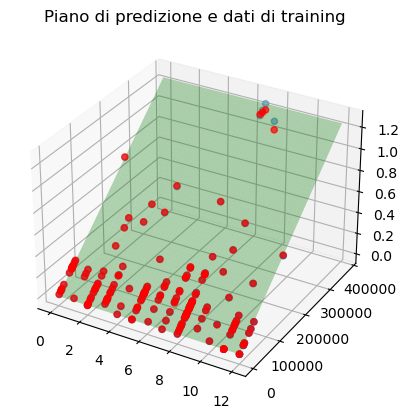

In [85]:
xy = pd.DataFrame({
                    'id_tag': daTag['id_tag'].values,
                    'likes' : daTag['likes' ].values
                  })

z  = daTag["views"]

xy_train, xy_valid, z_train, z_valid = train_test_split(xy, z, test_size=0.2, random_state=1)

regressor = LinearRegression()
lin_reg = regressor.fit(xy_train, z_train)

z_pred_train = plot_3d_prediction(xy_valid, z_valid, "id_tag", "likes", lin_reg, plt)


>Il risultato ottenuto è buono, nonostante la matrice di correlazione creata precedentemente sulle stesse variabili non mostrasse una correllazione molto forte tra quest'ultime. <br>
Difatti riteniamo che la qualità di questo modello predittivo sia molto influenzata dalla forte correlazione tra likes e views.<br>
Confermiamo la bontà del modello confrontando le statistiche di questo modello con quello nullo.

In [92]:
print("Statistiche Modello sugli anni:")
print ('MAE: \t',  MAE(list(z_valid), list(z_pred_train)))
print ('MSE: \t',  MSE(list(z_valid), list(z_pred_train)))
print ('RMSE:\t',  RMSE(list(z_valid), list(z_pred_train)))

#calcolate lo score medio
mean = z_valid.mean()

# create la nuova x con lo stesso numero di campioni del validation set originale, e con tutti i valori uguali al valore medio dello score appena calcolato
null_model_z = [mean] * z_valid.shape[0]

print("Statistiche Modello nullo:")
print ('MAE: \t',  MAE(list(z_valid), list(null_model_z)))
print ('MSE: \t',  MSE(list(z_valid), list(null_model_z)))
print ('RMSE:\t',  RMSE(list(z_valid), list(null_model_z)))

Statistiche Modello sugli anni:
MAE: 	 35422.88881090635
MSE: 	 6877903360.382176
RMSE:	 82933.12583269834
Statistiche Modello nullo:
MAE: 	 1291915.0632866025
MSE: 	 4493592532924.092
RMSE:	 2119809.5510974783


> Anche in questo caso ci vengonoo che i risultati degli errori statistici sul nostro modello sono molto più piccoli rispetto a quelli sul modello nullo confermando la bontà del modello.

# 5. Clustering

>## Clustering date_int, views e likes
Abbiamo cercato di fare il clustering, così da vedere e o ricercare le corrispondenze, tra la data, le visualizzazione e i like dei vari video Ted prensenti nel nostro dataset.<br>

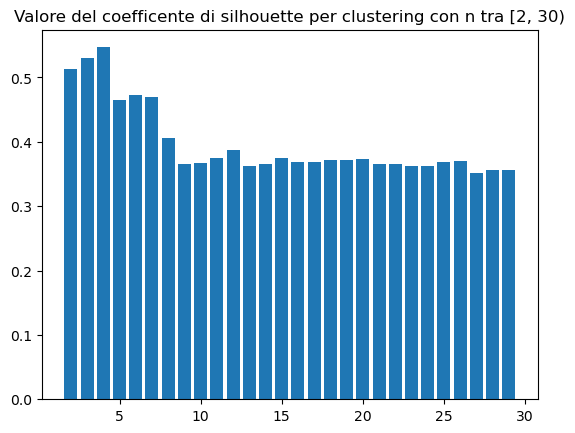

Il numero di cluster massimo individuato è:  4 
Stampa del grafico clusterizzato con 4 cluster


(0.5468978106887394,
 array([[0.92749606, 0.02002601, 0.02086015],
        [0.76784786, 0.02173431, 0.02257194],
        [0.80488485, 0.5138853 , 0.52791124],
        [0.84285049, 0.13875267, 0.14566173]]))

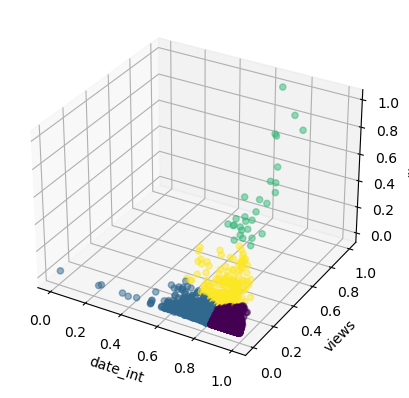

In [101]:
daTed['date_int'] = daTed['date'].astype(int)
sil_list = []
max_k = 0

for k in range(2, 30):
    r, _ = plot_3d_clusters(daTed, 'date_int', 'views', 'likes', k)
    sil_list.append (r)
    if(sil_list[max_k] < sil_list[len(sil_list)-1]):
        max_k = len(sil_list)-1

plt.title("Valore del coefficente di silhouette per clustering con n tra [2, 30)")
plt.bar([x for x in range(2,30)], sil_list)
plt.show()
        
print(
      "Il numero di cluster massimo individuato è: ", max_k+2, 
      "\nStampa del grafico clusterizzato con", max_k+2, "cluster"
     )


plot_3d_clusters(daTed, 'date_int', 'views', 'likes', max_k+2, make_plot=1)

>Con i seguenti centroidi ottenuti, si potrebbe pensare di aver suddiviso il dataset in 4 parti dove: 
>+ (viola) con il centroide con valori (data = 0.92749606, view = 0.02002601 e like = 0.02086015) corrisponde la  parte dei ted più recenti ma con meno like e views
>+ (blue) con il centroide con valori (data = 0.76784786, view = 0.02173431 e like =  0.02257194) corrisponde la parte dei ted più vecchia
>+ (verde) con il centroide con valori (data = 0.80488485, view = 0.5138853  e like =  0.52791124) corrisponde la parte dei ted tra gli anni 2015-2020 con più like e più views
>+ (gialla) con il centroide con valori (data = 0.84285049, view =  0.13875267 e like = 0.14566173) i ted talk con data compresa probabilmente tra gli anni 2015-2020 con i like e view più bassi